In [16]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


Bad key "axes.titlelocation" on line 298 in
C:\Users\My PC\Desktop\data\matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [17]:

from __future__ import division, print_function

from gensim.models import Word2Vec
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string

In [18]:

df=pd.read_csv('news.csv')
#Get shape and head
df.shape
pos = []
Label=[]
neg = []
for l in df.label:
    if l == 'FAKE':
        pos.append(0)
        Label.append(0)
        neg.append(1)
    elif l == 'REAL':
        pos.append(1)
        Label.append(1)
        neg.append(0)
df['Pos']= pos
df['Neg']= neg
df['Label']=Label

In [19]:
dfd=pd.DataFrame()
dfd['Text']=df['text']
dfd['Label']=df['Label']
dfd['Pos']=df['Pos']
dfd['Neg']=df['Neg']
dfd

,Text,Label,Pos,Neg
0,"Daniel Greenfield, a Shillman Journalism Fello...",0,0,1
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0,0,1
2,U.S. Secretary of State John F. Kerry said Mon...,1,1,0
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0,0,1
4,It's primary day in New York and front-runners...,1,1,0
...,...,...,...,...
6330,The State Department told the Republican Natio...,1,1,0
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0,0,1
6332,Anti-Trump Protesters Are Tools of the Oligar...,0,0,1
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",1,1,0


In [20]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

dfd['Text_Clean'] = dfd['Text'].apply(lambda x: remove_punct(x))
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in dfd.Text_Clean]
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens] 
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stoplist]

In [21]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 
result = [' '.join(sen) for sen in filtered_words]
dfd['Text_Final'] = result
dfd['tokens'] = filtered_words
dfd = dfd[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg']]
dfd[:4]

,Text_Final,tokens,Label,Pos,Neg
0,daniel greenfield shillman journalism fellow f...,"[daniel, greenfield, shillman, journalism, fel...",0,0,1
1,google pinterest digg linkedin reddit stumbleu...,"[google, pinterest, digg, linkedin, reddit, st...",0,0,1
2,us secretary state john f kerry said monday st...,"[us, secretary, state, john, f, kerry, said, m...",1,1,0
3,— kaydee king kaydeeking november 9 2016 lesso...,"[—, kaydee, king, kaydeeking, november, 9, 201...",0,0,1


In [22]:
data_train, data_test = train_test_split(dfd, test_size=0.10, random_state=42)
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

2619824 words total, with a vocabulary size of 85395
Max sentence length is 10786


In [23]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

291992 words total, with a vocabulary size of 28160
Max sentence length is 2892


In [24]:

import tensorflow
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz' 
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [25]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [26]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 85394 unique tokens.


In [27]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(85395, 300)


In [28]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
label_names = ['Pos', 'Neg']
y_train = data_train[label_names].values
x_train = train_cnn_data
y_tr = y_train


In [29]:
def recurrent_nn(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

#     lstm = LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedded_sequences)
    lstm = LSTM(256)(embedded_sequences)
    
    x = Dense(128, activation='relu')(lstm)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [30]:
model = recurrent_nn(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           25618500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 26,222,022
Trainable params: 603,522
No

In [31]:
num_epochs = 5
batch_size = 34
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Train on 5130 samples, validate on 571 samples
Epoch 1/5
5130/5130 [==============================] - 50s 10ms/step - loss: 0.5424 - acc: 0.7210 - val_loss: 0.4297 - val_acc: 0.8109
Epoch 2/5
5130/5130 [==============================] - 51s 10ms/step - loss: 0.3803 - acc: 0.8334 - val_loss: 0.4178 - val_acc: 0.8205
Epoch 3/5
5130/5130 [==============================] - 51s 10ms/step - loss: 0.3210 - acc: 0.8571 - val_loss: 0.3617 - val_acc: 0.8485
Epoch 4/5
5130/5130 [==============================] - 53s 10ms/step - loss: 0.2734 - acc: 0.8846 - val_loss: 0.3444 - val_acc: 0.8485
Epoch 5/5
5130/5130 [==============================] - 52s 10ms/step - loss: 0.2255 - acc: 0.9055 - val_loss: 0.3151 - val_acc: 0.8713


In [43]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)
print(prediction_labels)

634/634 [==============================] - 1s 2ms/step


In [33]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])
    

In [34]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.8406940063091483

In [35]:
print(prediction_labels)

[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 

In [36]:
labels=df.label
labels.head()


0    FAKE
1    FAKE
2    REAL
3    FAKE
4    REAL
Name: label, dtype: object

In [37]:
x_train,x_test,y_train,y_test=train_test_split(df['text'], labels, test_size=0.2, random_state=7)

In [38]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)
#DataFlair - Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

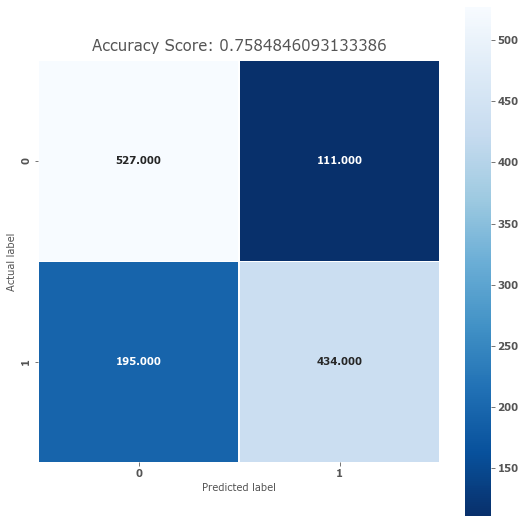

In [39]:

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(tfidf_train, y_train)

# Predict the Test set results, find accuracy
y_pred = clf.predict(tfidf_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm
score=clf.score(tfidf_test,y_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

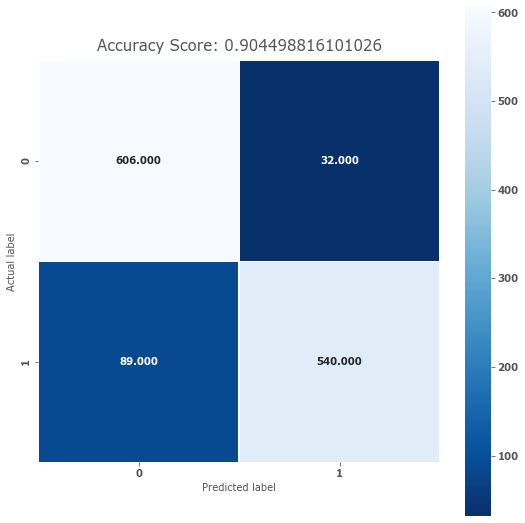

In [40]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None)
clf.fit(tfidf_train, y_train)

# Predict the Test set results, find accuracy
y_pred = clf.predict(tfidf_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm
score=clf.score(tfidf_test,y_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

C:\Users\My PC\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


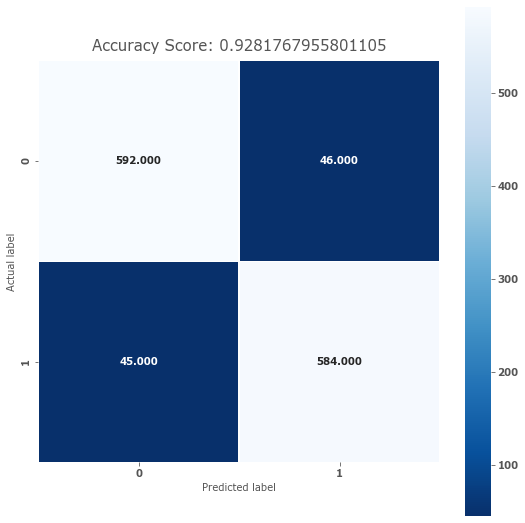

In [41]:
clf=PassiveAggressiveClassifier(max_iter=5,random_state=0)
clf.fit(tfidf_train, y_train)

# Predict the Test set results, find accuracy
y_pred = clf.predict(tfidf_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm
score=clf.score(tfidf_test,y_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

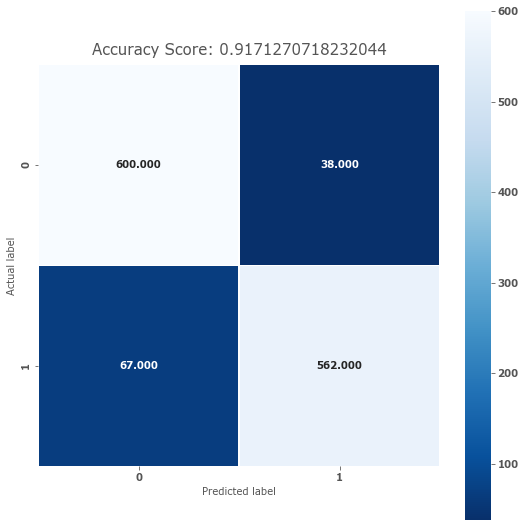

In [42]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(tfidf_train, y_train)

# Predict the Test set results, find accuracy
y_pred = clf.predict(tfidf_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm
score=clf.score(tfidf_test,y_test)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);